In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Inflation

In [33]:
data = pd.read_csv('data/estat_prc_hicp_manr_filtered_en.csv')

In [34]:
data.columns
df = data[['geo', 'TIME_PERIOD', 'OBS_VALUE']]
df.loc[:,'TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y-%m')

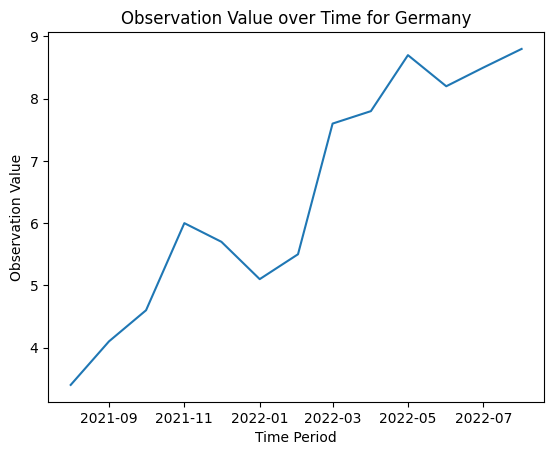

In [35]:
country = 'Germany'

plt.plot(df[df['geo'] == country]['TIME_PERIOD'], df[df['geo'] == country]['OBS_VALUE'])
plt.xlabel('Time Period')
plt.ylabel('Observation Value')
plt.title(f'Observation Value over Time for {country}')
plt.show()

/home/jeanluca/.pyenv/versions/lewagon/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


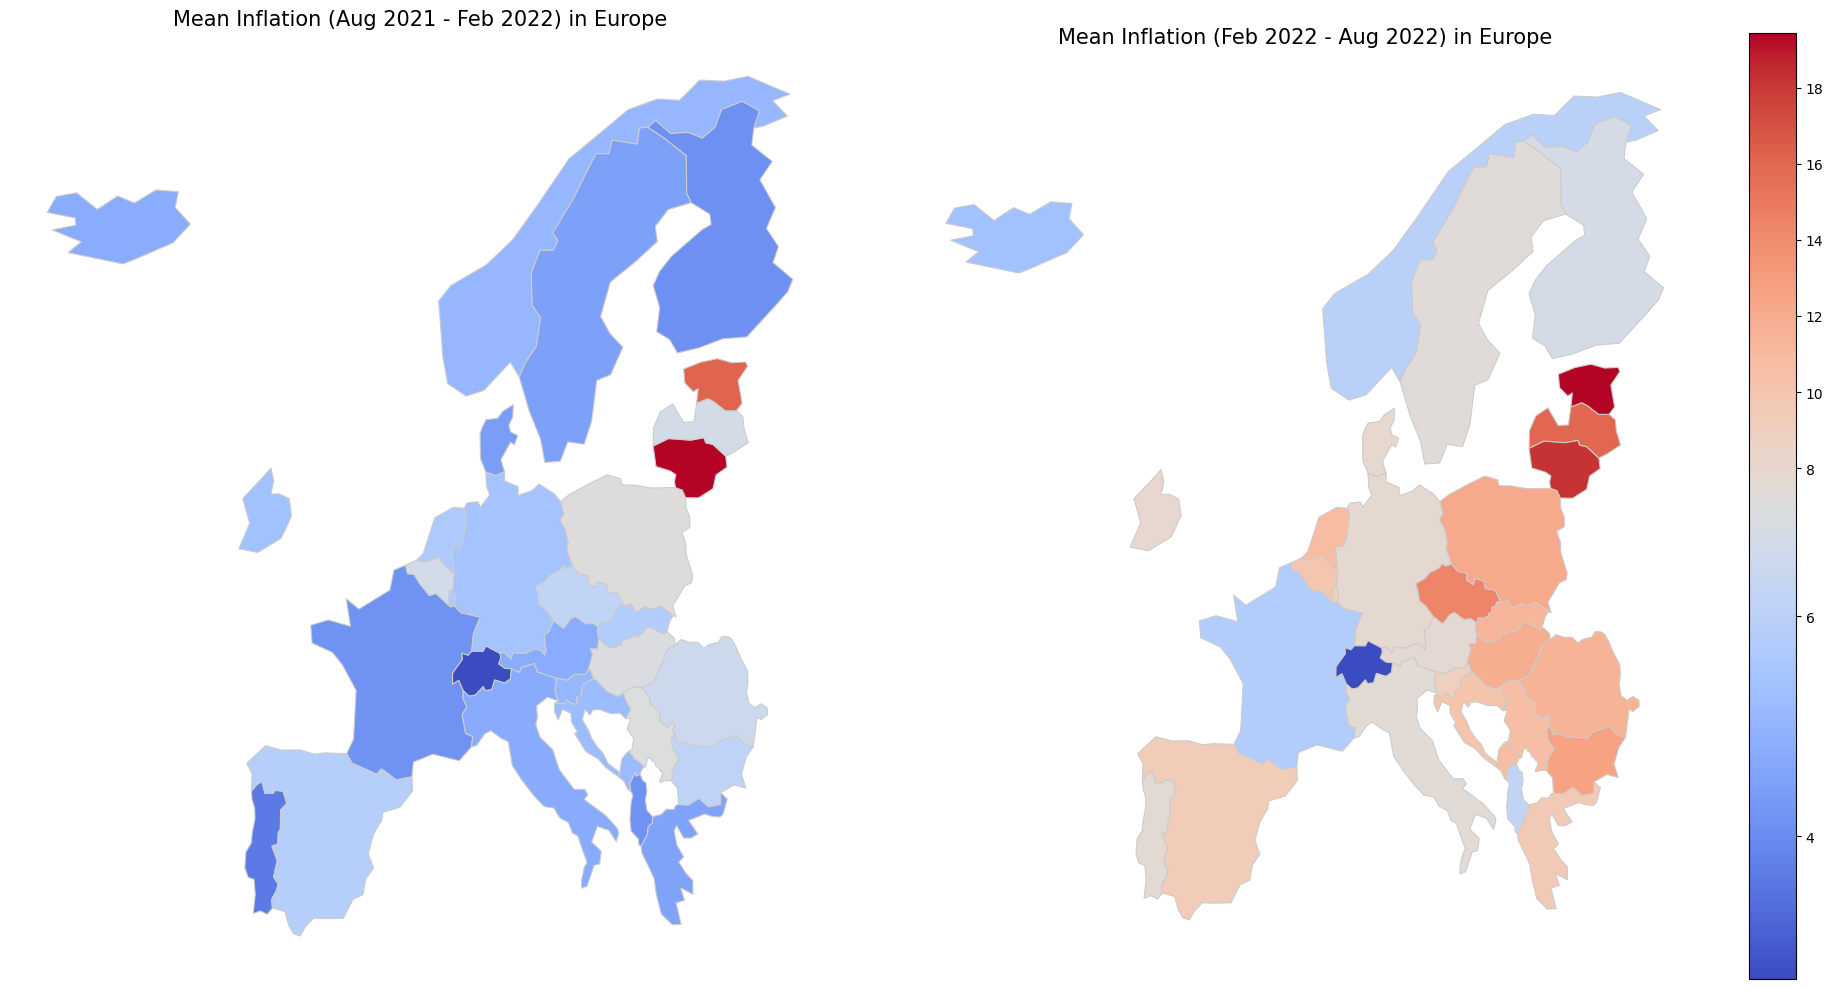

In [36]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from shapely.geometry import MultiPolygon

# Assume your DataFrame is named df and make a copy to work on
data = df.copy()

# Convert TIME_PERIOD to datetime
data['TIME_PERIOD'] = pd.to_datetime(data['TIME_PERIOD'])

# Load world map and filter for European countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

# Remove small islands (like the Azores) by keeping only the largest polygon in each multipolygon
def keep_largest(geom):
    if geom.type == 'MultiPolygon':
        return max(geom.geoms, key=lambda a: a.area)
    else:
        return geom

europe['geometry'] = europe['geometry'].apply(keep_largest)

# ---------------------------
# Period 1: Aug 2021 - Feb 2022
# ---------------------------
mask1 = (data['TIME_PERIOD'] >= pd.to_datetime('2021-08-01')) & (data['TIME_PERIOD'] <= pd.to_datetime('2022-02-01'))
data_filtered1 = data.loc[mask1]

# Group by country and compute the mean inflation for period 1
inflation_by_country1 = data_filtered1.groupby('geo')['OBS_VALUE'].mean().reset_index()
inflation_by_country1.rename(columns={'OBS_VALUE': 'mean_inflation'}, inplace=True)

# Merge with European geodataframe (ensure country names match)
europe_inflation1 = europe.merge(inflation_by_country1, left_on='name', right_on='geo', how='left')

# Create normalization centered at 7
vmin1 = europe_inflation1['mean_inflation'].min()
vmax1 = europe_inflation1['mean_inflation'].max()
norm1 = TwoSlopeNorm(vmin=vmin1, vcenter=7, vmax=vmax1)

# ---------------------------
# Period 2: Feb 2022 - Aug 2022
# ---------------------------
mask2 = (data['TIME_PERIOD'] >= pd.to_datetime('2022-02-01')) & (data['TIME_PERIOD'] <= pd.to_datetime('2022-08-01'))
data_filtered2 = data.loc[mask2]

# Group by country and compute the mean inflation for period 2
inflation_by_country2 = data_filtered2.groupby('geo')['OBS_VALUE'].mean().reset_index()
inflation_by_country2.rename(columns={'OBS_VALUE': 'mean_inflation'}, inplace=True)

# Merge with European geodataframe
europe_inflation2 = europe.merge(inflation_by_country2, left_on='name', right_on='geo', how='left')

# Create normalization centered at 7 for period 2
vmin2 = europe_inflation2['mean_inflation'].min()
vmax2 = europe_inflation2['mean_inflation'].max()
norm2 = TwoSlopeNorm(vmin=vmin2, vcenter=7, vmax=vmax2)

# ---------------------------
# Plot side by side
# ---------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot Period 1 without legend
europe_inflation1.plot(column='mean_inflation', cmap='coolwarm', linewidth=0.8,
                       ax=ax1, edgecolor='0.8', legend=False, norm=norm1)
ax1.set_title('Mean Inflation (Aug 2021 - Feb 2022) in Europe', fontsize=15)
ax1.axis('off')

# Plot Period 2 with legend
europe_inflation2.plot(column='mean_inflation', cmap='coolwarm', linewidth=0.8,
                       ax=ax2, edgecolor='0.8', legend=True, norm=norm2)
ax2.set_title('Mean Inflation (Feb 2022 - Aug 2022) in Europe', fontsize=15)
ax2.axis('off')

plt.tight_layout()
plt.show()


In [37]:
selected_countries = ["Germany",
"France",
"Netherlands",
"Italy",
"Spain",
"Estonia",
"Latvia",
"Lithuania",
"Poland",
"Finland",
"Sweden",
"Denmark",
"Greece",
"Portugal",
"Cyprus",
"United Kingdom",
"Austria",
"Czechia",
"Hungary",
"Slovakia",
"Bulgaria",
"Croatia",
"Romania",
"Slovenia",
"Serbia"]

In [38]:
# Sort the DataFrame by country and time
df_sorted = df.sort_values(['geo', 'TIME_PERIOD'])
# df_sorted = df_sorted[~df_sorted['geo'].isin(selected_countries)]
# df_sorted = df_sorted[df_sorted['geo'].isin(selected_countries)]

# Group by country and compute the first and last inflation values
diff_df = df_sorted.groupby('geo').agg(
    first_inflation=('OBS_VALUE', 'first'),
    last_inflation=('OBS_VALUE', 'last')
).reset_index()

# Compute the inflation change for each country
diff_df['inflation_change'] = diff_df['last_inflation'] - diff_df['first_inflation']

# Count how many countries have an increase in inflation (change > 0)
num_countries_increase = (diff_df['inflation_change'] > 0).sum()

print("Number of countries with an increase in inflation:", num_countries_increase)
print("Number of countries in dataset:", len(df_sorted.geo.unique()))
diff_df.sort_values(by=['inflation_change'], ascending=False)

Number of countries with an increase in inflation: 34
Number of countries in dataset: 34


,geo,first_inflation,last_inflation,inflation_change
8,Estonia,5.0,25.2,20.2
18,Latvia,3.6,21.4,17.8
19,Lithuania,5.0,21.1,16.1
6,Czechia,3.1,17.1,14.0
14,Hungary,4.9,18.6,13.7
3,Bulgaria,2.5,15.0,12.5
23,Netherlands,2.7,13.7,11.0
29,Slovakia,3.3,13.4,10.1
22,Montenegro,3.8,13.9,10.1
13,Greece,1.2,11.2,10.0


# Distance from Kiev

In [39]:
import pandas as pd
from geopy.distance import geodesic

# Coordinates for Kyiv (capital of Ukraine)
kyiv_coords = (50.4501, 30.5234)

# Dictionary of European countries, their capitals, and the coordinates (latitude, longitude) of each capital.
# (Note: These coordinates are approximate.)
european_capitals = {
    "Albania": {"capital": "Tirana", "coords": (41.3275, 19.8187)},
    "Andorra": {"capital": "Andorra la Vella", "coords": (42.5063, 1.5218)},
    "Armenia": {"capital": "Yerevan", "coords": (40.1811, 44.5136)},
    "Austria": {"capital": "Vienna", "coords": (48.2082, 16.3738)},
    "Azerbaijan": {"capital": "Baku", "coords": (40.4093, 49.8671)},
    "Belarus": {"capital": "Minsk", "coords": (53.9045, 27.5615)},
    "Belgium": {"capital": "Brussels", "coords": (50.8503, 4.3517)},
    "Bosnia and Herzegovina": {"capital": "Sarajevo", "coords": (43.8563, 18.4131)},
    "Bulgaria": {"capital": "Sofia", "coords": (42.6977, 23.3219)},
    "Croatia": {"capital": "Zagreb", "coords": (45.8150, 15.9819)},
    "Cyprus": {"capital": "Nicosia", "coords": (35.1856, 33.3823)},
    "Czech Republic": {"capital": "Prague", "coords": (50.0755, 14.4378)},
    "Denmark": {"capital": "Copenhagen", "coords": (55.6761, 12.5683)},
    "Estonia": {"capital": "Tallinn", "coords": (59.4370, 24.7536)},
    "Finland": {"capital": "Helsinki", "coords": (60.1699, 24.9384)},
    "France": {"capital": "Paris", "coords": (48.8566, 2.3522)},
    "Georgia": {"capital": "Tbilisi", "coords": (41.7151, 44.8271)},
    "Germany": {"capital": "Berlin", "coords": (52.5200, 13.4050)},
    "Greece": {"capital": "Athens", "coords": (37.9838, 23.7275)},
    "Hungary": {"capital": "Budapest", "coords": (47.4979, 19.0402)},
    "Iceland": {"capital": "Reykjavik", "coords": (64.1466, -21.9426)},
    "Ireland": {"capital": "Dublin", "coords": (53.3498, -6.2603)},
    "Italy": {"capital": "Rome", "coords": (41.9028, 12.4964)},
    "Kosovo": {"capital": "Pristina", "coords": (42.6629, 21.1655)},
    "Latvia": {"capital": "Riga", "coords": (56.9496, 24.1052)},
    "Liechtenstein": {"capital": "Vaduz", "coords": (47.1410, 9.5215)},
    "Lithuania": {"capital": "Vilnius", "coords": (54.6872, 25.2797)},
    "Luxembourg": {"capital": "Luxembourg", "coords": (49.6116, 6.1319)},
    "Malta": {"capital": "Valletta", "coords": (35.8989, 14.5146)},
    "Moldova": {"capital": "Chisinau", "coords": (47.0105, 28.8638)},
    "Monaco": {"capital": "Monaco", "coords": (43.7384, 7.4246)},
    "Montenegro": {"capital": "Podgorica", "coords": (42.4304, 19.2594)},
    "Netherlands": {"capital": "Amsterdam", "coords": (52.3676, 4.9041)},
    "North Macedonia": {"capital": "Skopje", "coords": (41.9981, 21.4254)},
    "Norway": {"capital": "Oslo", "coords": (59.9139, 10.7522)},
    "Poland": {"capital": "Warsaw", "coords": (52.2297, 21.0122)},
    "Portugal": {"capital": "Lisbon", "coords": (38.7223, -9.1393)},
    "Romania": {"capital": "Bucharest", "coords": (44.4268, 26.1025)},
    "Russia": {"capital": "Moscow", "coords": (55.7558, 37.6173)},
    "San Marino": {"capital": "San Marino", "coords": (43.9424, 12.4578)},
    "Serbia": {"capital": "Belgrade", "coords": (44.7866, 20.4489)},
    "Slovakia": {"capital": "Bratislava", "coords": (48.1486, 17.1077)},
    "Slovenia": {"capital": "Ljubljana", "coords": (46.0569, 14.5058)},
    "Spain": {"capital": "Madrid", "coords": (40.4168, -3.7038)},
    "Sweden": {"capital": "Stockholm", "coords": (59.3293, 18.0686)},
    "Switzerland": {"capital": "Bern", "coords": (46.9480, 7.4474)},
    "Turkey": {"capital": "Ankara", "coords": (39.9334, 32.8597)},
    "United Kingdom": {"capital": "London", "coords": (51.5074, -0.1278)}
}

# List to store computed distances
results = []

# Calculate the distance from each capital to Kyiv
for country, info in european_capitals.items():
    capital = info["capital"]
    coords = info["coords"]
    distance_km = geodesic(kyiv_coords, coords).kilometers
    results.append({
        "Country": country,
        "Capital": capital,
        "Distance_to_Kyiv_km": distance_km
    })

# Create a DataFrame from the results
df_distances = pd.DataFrame(results)

# Optionally, sort by distance for clarity
df_distances = df_distances.sort_values("Distance_to_Kyiv_km")


In [40]:
# merge diff_df and df_distances
diff_df = diff_df.merge(df_distances, left_on='geo', right_on='Country', how='left')
diff_df

,geo,first_inflation,last_inflation,inflation_change,Country,Capital,Distance_to_Kyiv_km
0,Albania,2.6,7.7,5.1,Albania,Tirana,1308.176967
1,Austria,3.2,9.3,6.1,Austria,Vienna,1056.515015
2,Belgium,4.7,10.5,5.8,Belgium,Brussels,1841.801073
3,Bulgaria,2.5,15.0,12.5,Bulgaria,Sofia,1022.342657
4,Croatia,3.1,12.6,9.5,Croatia,Zagreb,1196.100004
5,Cyprus,3.3,9.6,6.3,Cyprus,Nicosia,1711.430529
6,Czechia,3.1,17.1,14.0,NaN,NaN,NaN
7,Denmark,1.8,9.9,8.1,Denmark,Copenhagen,1331.619984
8,Estonia,5.0,25.2,20.2,Estonia,Tallinn,1065.607389
9,European Union - 27 countries (from 2020),3.2,10.1,6.9,NaN,NaN,NaN


In [41]:
diff_df

,geo,first_inflation,last_inflation,inflation_change,Country,Capital,Distance_to_Kyiv_km
0,Albania,2.6,7.7,5.1,Albania,Tirana,1308.176967
1,Austria,3.2,9.3,6.1,Austria,Vienna,1056.515015
2,Belgium,4.7,10.5,5.8,Belgium,Brussels,1841.801073
3,Bulgaria,2.5,15.0,12.5,Bulgaria,Sofia,1022.342657
4,Croatia,3.1,12.6,9.5,Croatia,Zagreb,1196.100004
5,Cyprus,3.3,9.6,6.3,Cyprus,Nicosia,1711.430529
6,Czechia,3.1,17.1,14.0,NaN,NaN,NaN
7,Denmark,1.8,9.9,8.1,Denmark,Copenhagen,1331.619984
8,Estonia,5.0,25.2,20.2,Estonia,Tallinn,1065.607389
9,European Union - 27 countries (from 2020),3.2,10.1,6.9,NaN,NaN,NaN


In [45]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

# Copy the dataset
df = diff_df.copy()

# Define independent and dependent variables
df["log_distance"] = np.log(df["Distance_to_Kyiv_km"])  # Log transform distance

# First-stage regressions
first_stage_before = smf.ols("first_inflation ~ log_distance", data=df).fit()
first_stage_after = smf.ols("last_inflation ~ log_distance", data=df).fit()

# Display results
print("First-Stage Regression BEFORE WAR:")
print(first_stage_before.summary())
print(f"First-Stage F-Statistic (Before War): {first_stage_before.fvalue}\n")

print("First-Stage Regression AFTER WAR:")
print(first_stage_after.summary())
print(f"First-Stage F-Statistic (After War): {first_stage_after.fvalue}\n")

First-Stage Regression BEFORE WAR:
                            OLS Regression Results                            
Dep. Variable:        first_inflation   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     7.885
Date:                Wed, 19 Mar 2025   Prob (F-statistic):            0.00868
Time:                        19:54:03   Log-Likelihood:                -47.617
No. Observations:                  32   AIC:                             99.23
Df Residuals:                      30   BIC:                             102.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


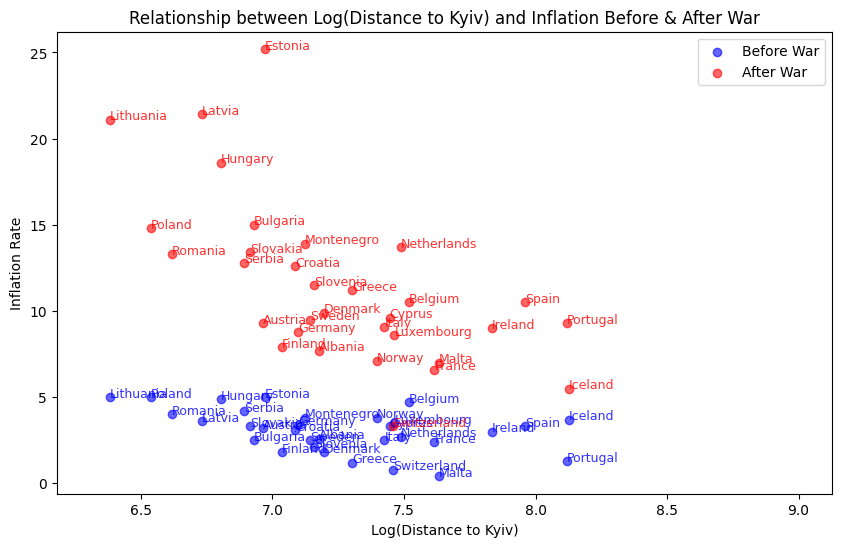

In [49]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plots
ax.scatter(df["log_distance"], df["first_inflation"], alpha=0.6, label="Before War", color='blue')
ax.scatter(df["log_distance"], df["last_inflation"], alpha=0.6, label="After War", color='red')

# Add country names
for i, row in df.iterrows():
    ax.text(row["log_distance"], row["first_inflation"], row["geo"], fontsize=9, color='blue', alpha=0.8)
    ax.text(row["log_distance"], row["last_inflation"], row["geo"], fontsize=9, color='red', alpha=0.8)

# Labels and title
ax.set_xlabel("Log(Distance to Kyiv)")
ax.set_ylabel("Inflation Rate")
ax.set_title("Relationship between Log(Distance to Kyiv) and Inflation Before & After War")
ax.legend()

# Ensure same axis limits
ax.set_xlim([df["log_distance"].min() - 0.2, df["log_distance"].max() + 1])
y_min = min(df["first_inflation"].min(), df["last_inflation"].min()) - 1
y_max = max(df["first_inflation"].max(), df["last_inflation"].max()) + 1
ax.set_ylim([y_min, y_max])

plt.show()